In [1]:
!pip install tf-agents

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 KB 47.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 19.7 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697661 sha256=74dd9cb00fee01369fea7fc383189e2b9c6b7b720b17358ec7defcbd3d0b824e
  Stored in directory: /root/.cache/pip/wheels/96/b9/bb/994c1324b65e39dd1cd7b8ba92e5fb766dd77980929414a866
Successfully built gym
  Attempting uninstall: pygame
    Found existing installation: pygame 2.3.0
    Uninstalling pygame-2.3.0:
      Successfully uninstalled pygame-2.3.0
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25

In [2]:
import gym
from gym import spaces
import tensorflow as tf
import tensorflow_probability as tfp

In [3]:
import numpy as np
import pandas as pd
import copy
import random
import itertools
from collections.abc import Iterable

In [ ]:
'''
Modified Environment for "Multi-period Newsvendor Problem with Lead Times": 
Reference/Source (OR GYM): https://github.com/hubbs5/or-gym/blob/master/or_gym/envs/classic_or/newsvendor.py

Multi-Period Newsvendor with Lead Times:

The MPNV requires meeting stochastic demand to satisfy customers by having sufficient inventory on hand. 
The inventory orders are not instantaneous and have multi-period lead times. 
Additionally, there are costs associated with holding unsold inventory, however unsold inventory expires at the end of each period.
'''

'''
Modifications made to the following parts:
  1. add the operations of demand forecasting for a whole lead time period instead of capturing only the next time-step demand
  2. calculate the current supply-demand planning gap by the excess or shortage stocks
  3. set constraints for the ordered quantities depending on the excess or shortage stocks computed
  4. calculation formula for "purchase cost"
  5. update the first 5 positions of the state vector in each training step instead of once per episode
'''

In [ ]:
class m_NewsVendorEnv(gym.Env):
    
    def __init__(self, *args, **kwargs):
        self.lead_time = 7
        self.max_inventory = 4000           # Max reserved inventory
        self.min_inventory = 200            # Min safety stock inventory
        self.max_order_quantity = 1000      # Max productivity
        self.min_order_quantity = 100       # Min lotsize in purchase order
        self.step_limit = 52
        self.p_max = 300        # Max sale price
        self.h_max = 10         # Max holding cost
        self.k_max = 25         # Max lost sales penalty
        self.mu_max = 400       # Max mean of the demand distribution
        self.mu_min = 200       # Min mean of the demand distribution
        self.mu_adj_sd = 0.2    # SD for demand adjustment per time step
        self.gamma = 1.0        # Discount factor
        
        self.assign_env_config(**kwargs)

        self.observation_space = spaces.Box(
            low = np.array(
                [self.p_max * 0.1, self.p_max * 0.1 * 0.1, 0, 0, self.mu_min] +
                [np.zeros(1)] * self.lead_time,
            dtype=np.float32),
            high = np.array(
                [self.p_max, self.p_max, self.h_max, self.k_max, self.mu_max] +
                [self.max_order_quantity] * self.lead_time,
            dtype=np.float32)
        )
        self.action_space = spaces.Box(
            low = np.zeros(1), 
            high = np.array([self.max_order_quantity]), 
            dtype=np.float32)
        
        self.initial_mu = max(self.mu_min, np.random.rand() * self.mu_max)
        self.forecast_demand = np.random.poisson(lam = self.initial_mu, size = self.lead_time)

        self.reset()
        
    def assign_env_config(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)
        if hasattr(self, 'env_config'):
            for key, value in self.env_config.items():
                # Check types based on default settings
                if hasattr(self, key):
                    if type(getattr(self,key)) == np.ndarray:
                        setattr(self, key, value)
                    else:
                        setattr(self, key,
                            type(getattr(self, key))(value))
                else:
                    raise AttributeError(f"{self} has no attribute, {key}")

    def _STEP(self, action):
        done = False

        ## Step 1)  Demand re-adjustment
        #### Poisson Mixture of demand distribution
        current_demand = self.forecast_demand[0]
        new_demand = np.random.poisson(lam = self.mu)
        #### Update for demand variations
        self.forecast_demand[1:] = [x * (1 + np.random.normal(0, self.mu_adj_sd)) for x in self.forecast_demand[1:]]
        demand_vector = self.forecast_demand
        self.forecast_demand[:-1] = self.forecast_demand[1:]
        self.forecast_demand[-1] = new_demand

        ## Step 2)  Check current inventory status after consuming demand at current time
        #### Current inventory
        inventory = self.state[5:]
        inv_on_hand = inventory[0]
        #### sales figures, fulfillment of orders
        sales = min(inv_on_hand, current_demand) * self.price
        excess_inventory = max(0, inv_on_hand - current_demand)
        short_inventory = max(0, current_demand - inv_on_hand)
        #### current supply-demand planning gap
        gap = 0
        for t in range(1, len(inventory)-1):
            gap += demand_vector[t] - inventory[t]

        ## Step 3)  Set constraints for order quantity at future lead time
        #### constrainted order quantity
        if short_inventory > 0:
            order_qty = min(max(0, self.max_inventory - inventory[1:].sum()), max(action, short_inventory + gap + self.min_inventory))
        if excess_inventory > 0:
            order_qty = min(max(0, self.max_inventory - inventory[1:].sum()), max(action, gap - excess_inventory + self.min_inventory))
        if short_inventory == 0 and excess_inventory == 0:
            order_qty = action
        if order_qty > 0:
            order_qty = min(max(order_qty, self.min_order_quantity), self.max_order_quantity)
            
        ## Step 4)  Reward mechanism
        purchase_cost = order_qty * self.cost * self.gamma ** self.lead_time
        holding_cost = excess_inventory * self.h
        lost_sales_penalty = short_inventory * self.k
        
        reward = sales - purchase_cost - holding_cost - lost_sales_penalty

        ## Step 5)  Update state vector
        new_inventory = np.zeros(self.lead_time)
        new_inventory[:-1] += inventory[1:]
        new_inventory[-1] += order_qty
        new_inventory[0] = new_inventory[0] + excess_inventory - short_inventory
        self.state = np.hstack([self.state[:5], new_inventory])
        
        ## log environment parameters
        self.short_inventory = short_inventory
        self.excess_inventory = excess_inventory
        self.sales = sales
        self.order_qty = order_qty

        self.state[0:5] = np.array([self.sales, self.order_qty, self.excess_inventory, self.short_inventory, self.forecast_demand[0]])

        self.step_count += 1
        if self.step_count >= self.step_limit:
            done = True
            
        return self.state, reward, done, {}

    def _RESET(self):
        ### Randomize costs
        self.price = max(self.p_max * 0.1, np.random.rand() * self.p_max)     ## min sales price = 10% max sales price
        self.cost = max(self.price * 0.1, np.random.rand() * self.price)      ## min cost = 10% sales price
        self.h = max(self.cost * 0.1, np.random.rand() * self.h_max)
        self.k = max(self.h * 1.1, np.random.rand() * self.k_max)
        self.mu = max(self.mu_min, np.random.rand() * self.mu_max)
        self.state = np.array(
                [self.price, self.cost, self.h, self.k, self.mu] +
                [np.zeros(1)] * self.lead_time,
            dtype=np.float32)
        ### Reset step counter
        self.step_count = 0
        return self.state

    def reset(self):
        return self._RESET()

    def step(self, action):
        return self._STEP(action)
    
    def seed(self,seed=None):
        # seed random state
        if seed != None:
            np.random.seed(seed=int(seed))

In [ ]:
## create space with paramters
env_config = {
              "lead_time": 7,
              "max_inventory": 4000,
              "min_inventory": 200,
              "max_order_quantity": 1000,
              "min_order_quantity": 100,
              "step_limit": 104,
              "p_max": 300,    
              "h_max": 10,      
              "k_max": 25,     
              "mu_max": 400,  
              "mu_min": 200, 
              "mu_adj_sd": 0.2,   
              "gamma": 1.0,      
              }

In [ ]:
## class methods
env = m_NewsVendorEnv(env_config)
initial_state = env.reset()
actions = env.action_space
states = env.observation_space

In [ ]:
print("Number of Actions per step: " + str(actions.shape[0]))

Number of Actions per step: 1


In [ ]:
print("Number of State Variables per step: " + str(states.shape[0]))

Number of State Variables per step: 12


In [ ]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Number of tuples to train on.
        self.batch_size = batch_size
        # Number of times record() was called.
        self.buffer_counter = 0
        self.state_buffer = np.zeros((self.buffer_capacity, states.shape[0]))
        self.action_buffer = np.zeros((self.buffer_capacity, actions.shape[0]))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, states.shape[0]))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded, replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. 
    # Decorating with tf.function allows TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch):

        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic([target_actions, next_state_batch], training=True)
            critic_value = critic_model([action_batch, state_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([actions, state_batch], training=True)
            # Used `-value` as we want to maximize the value given by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.5, dt=0.1, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)


# To update target parameters slowly based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))
        
        
## update policy
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise
    legal_action = np.clip(sampled_actions, actions.low, actions.high)
    return [np.squeeze(legal_action)]

In [ ]:
### Use Actor-Critic Network structure

class DDPGNet(tf.keras.Model):
    def __init__(self, n_layer, n_latent_dim: tuple, 
                 n_states, n_actions, batch_size):
        super(DDPGNet, self).__init__()

        assert n_layer > 1, "The number of latent layers should be greater than 1"
        assert len(n_latent_dim) == n_layer, "The tuple length of dimensions ('n_latent_dim') should be equal to or match with 'n_layer'."

        self.n_layer = n_layer
        self.n_latent_dim = n_latent_dim
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size
        
        self.action_input = tf.keras.Input(shape=(self.n_actions, ))

        self.actor_model = self.Actor()
        self.critic_model = self.Critic()
        self.target_actor = self.Actor()
        self.target_critic = self.Critic()

    def Actor(self):
        inputs_x = tf.keras.Input(shape=(self.n_states, ))
        x = tf.keras.layers.Dense(self.n_states, activation="relu")(inputs_x)
        for n in range(self.n_layer):
            x = tf.keras.layers.Dense(self.n_latent_dim[n], activation="relu")(x)
        x = tf.keras.layers.Dense(self.n_states, activation="relu")(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(self.n_actions, activation="linear")(x)

        m = tf.keras.Model(inputs = inputs_x, outputs = x)
        return m
    
    def Critic(self):
        action_input = self.action_input
        observation_input = tf.keras.Input(shape=(self.n_states, ))
        observation_out = tf.keras.layers.Dense(self.n_states, activation="relu")(observation_input)
        for n in range(self.n_layer):
            observation_out = tf.keras.layers.Dense(self.n_latent_dim[n], activation="relu")(observation_out)
        observation_out = tf.keras.layers.Dense(self.n_states, activation="relu")(observation_out)
        observation_out = tf.keras.layers.Flatten()(observation_out)
        
        x = tf.keras.layers.Concatenate()([action_input, observation_out])
        x = tf.keras.layers.Dense(self.n_states * 2, activation="relu")(x)
        x = tf.keras.layers.Dense(self.n_states * 2 * 8, activation="relu")(x)
        x = tf.keras.layers.Dense(self.n_states * 2 * 8, activation="relu")(x)
        x = tf.keras.layers.Dense(self.n_states * 2 * 2, activation="relu")(x)
        x = tf.keras.layers.Dense(self.n_states * 2 * 2, activation="relu")(x)
        x = tf.keras.layers.Dense(self.n_states, activation="relu")(x)
        x = tf.keras.layers.Dense(self.n_actions, activation="relu")(x)
        x = tf.keras.layers.Dense(1, activation="linear")(x)
        
        m = tf.keras.Model(inputs = [action_input, observation_input], outputs = x)
        return m

In [ ]:
## Define noise
std_dev = 2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

## Network class
ddpgNN = DDPGNet(n_layer = 6, 
                 n_latent_dim = (24, 48, 192, 192, 48, 24), 
                 n_states = states.shape[0], 
                 n_actions = actions.shape[0], 
                 batch_size = 16)
## Define actor networks
actor_model = ddpgNN.actor_model
critic_model = ddpgNN.critic_model
## Define critic networks
target_actor = ddpgNN.target_actor
target_critic = ddpgNN.target_critic

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

## Define optimizer
critic_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0005)
actor_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.00025)

## Define hyperparameters
total_episodes = 500
gamma = 0.99
tau = 0.005
buffer = Buffer(50000, 104)

In [ ]:
actor_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense (Dense)               (None, 12)                156       
                                                                 
 dense_1 (Dense)             (None, 24)                312       
                                                                 
 dense_2 (Dense)             (None, 48)                1200      
                                                                 
 dense_3 (Dense)             (None, 192)               9408      
                                                                 
 dense_4 (Dense)             (None, 192)               37056     
                                                                 
 dense_5 (Dense)             (None, 48)                9264  

In [ ]:
critic_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 dense_9 (Dense)                (None, 12)           156         ['input_3[0][0]']                
                                                                                                  
 dense_10 (Dense)               (None, 24)           312         ['dense_9[0][0]']                
                                                                                                  
 dense_11 (Dense)               (None, 48)           1200        ['dense_10[0][0]']               
                                                                                            

In [7]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []
std_reward_list = []
## logged_action
action_log = []

for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = []
    episodic_action = []

    while True:
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        action = policy(tf_prev_state, ou_noise)
        state, reward, done, info = env.step(action[0])

        buffer.record((prev_state, action[0], reward, state))
        episodic_reward.append(reward)
        episodic_action.append(action)

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean & SD
    avg_reward = np.mean(episodic_reward)
    sd_reward = np.std(episodic_reward)

    print("Episode " + str(ep+1) + ":   Average Reward = " + str(format(avg_reward, '.6f')) + \
          ";   SD Reward = " + str(format(sd_reward, '.6f')) + \
          ";   Action Qty (Mean) = " + str(format(np.mean(action), '.1f')))
    
    avg_reward_list.append(avg_reward)
    std_reward_list.append(sd_reward)
    action_log.append(np.mean(action))

Episode 1:   Average Reward = -47684.232178;   SD Reward = 0.000000;   Action Qty (Mean) = 0.0
Episode 2:   Average Reward = -78295.104491;   SD Reward = 20407.248209;   Action Qty (Mean) = 9.1
Episode 3:   Average Reward = -56440.167264;   SD Reward = 26499.142389;   Action Qty (Mean) = 13.2
Episode 4:   Average Reward = -47266.430410;   SD Reward = 25275.746102;   Action Qty (Mean) = 6.1
Episode 5:   Average Reward = -42792.674151;   SD Reward = 23381.017886;   Action Qty (Mean) = 2.3
Episode 6:   Average Reward = -39020.851061;   SD Reward = 22072.036025;   Action Qty (Mean) = 4.2
Episode 7:   Average Reward = -38520.890995;   SD Reward = 20451.037581;   Action Qty (Mean) = 2.0
Episode 8:   Average Reward = -41663.271000;   SD Reward = 19916.956334;   Action Qty (Mean) = 6.1
Episode 9:   Average Reward = -42286.034470;   SD Reward = 18814.568515;   Action Qty (Mean) = 4.0
Episode 10:   Average Reward = -48485.722673;   SD Reward = 21733.240091;   Action Qty (Mean) = 3.5
Episode 11: 

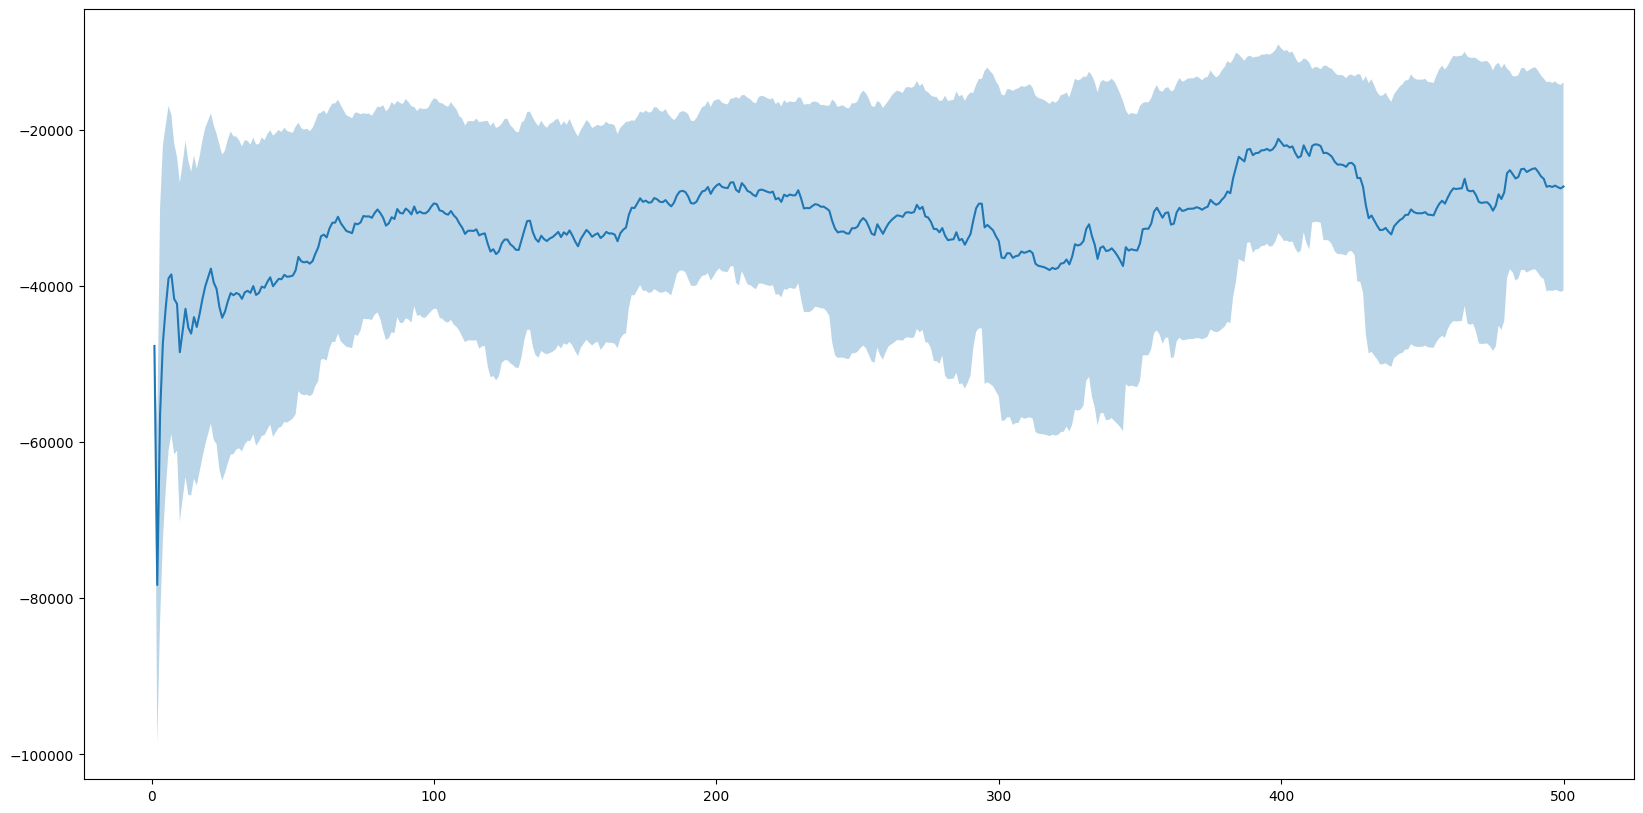

In [14]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))

"""
Training for 500 episodes (104 per each episode with a total equal to 52,000 steps), 
the average rewards returned gradually increased at a slow and fluctuating rate,
reflecting the sign of the agent learning steadily.
It can be seen the agent showing a negative return after 500 episodes of play, 
somehow it may be due to that the training parameter settings imported to the environment may not favour a profitable lead time chain,
but after all, the agent requires more episodes to explore, because the prices and costs in each play are randomized.
"""

plt.plot(np.array([n+1 for n in range(500)]), np.array(avg_reward_list))
plt.fill_between(np.array([n+1 for n in range(500)]), 
                 np.array(avg_reward_list) - np.array(std_reward_list), 
                 np.array(avg_reward_list) + np.array(std_reward_list), 
                 alpha=0.3)

In [ ]:
print("Price: " + str(round(env.price, 2)) + \
      ";  Cost: " + str(round(env.cost, 2)) + \
      ";  Holding Cost: " + str(round(env.h, 2)) + \
      ";  Loss-sale Backlog Cost: " + str(round(env.k, 2))
     )
print("\n")
print("Inventory for the 7-week lead time: ")
print([round(x, 0) for x in env.state[5:]])
print("\n")
print("Forecasted Demand for the 7-week lead time: ")
print([x for x in env.forecast_demand])
print("\n")
print("Total Sales at time step T0: " + str(round(env.sales, 2)))
print("Total Purchase Cost at time step T0: " + str(round(env.order_qty * env.cost * env.gamma ** env.lead_time, 2)))
print("Short Inventory at time step T0: " + str(round(env.short_inventory, 0)))
print("Excess Inventory at time step T0: " + str(round(env.excess_inventory, 0)))
print("\n")
print("Ordered Quantity: " + str(round(env.order_qty, 0)))
print("Agent Action Quantity: " + str(round(action[0].tolist(), 0)))

Price: 110.74;  Cost: 31.11;  Holding Cost: 9.73;  Loss-sale Backlog Cost: 15.7


Inventory for the 7-week lead time: 
[129.0, 375.0, 100.0, 100.0, 225.0, 199.0, 230.0]


Forecasted Demand for the 7-week lead time: 
[223, 283, 134, 320, 203, 219, 170]


Total Sales at time step T0: -15258.16
Total Purchase Cost at time step T0: 7154.76
Short Inventory at time step T0: 288.0
Excess Inventory at time step T0: 0


Ordered Quantity: 230.0
Agent Action Quantity: 133.0


In [ ]:
from numpy.random import poisson
from numpy.random import binomial
from numpy.random import negative_binomial
from numpy.random import geometric
from numpy.random import hypergeometric
from numpy.random import multinomial
from numpy.random import standard_exponential

In [ ]:
'''
Modified Environment for "Multi-echelon Inventory Management Problem with Backlogs": 
Reference/Source (OR GYM):  https://github.com/hubbs5/or-gym/blob/master/or_gym/envs/supply_chain/inventory_management.py
'''

'''
Modifications made to the following parts:
  1. setting a dynamically updating demand forecast for realistic demand planning process 
  2. setting constraints to cover the forecasted demand quantities, 
      i.e., letting the agents know in advance the forecasted demands in coming lead times
  3. passing the action updated with the base-stock-action policy function in the class object when making decision to get "action"
'''

'''
The supply chain inventory management with backlogs environment is structured as follows:

A)  Settings:
It is a multi-period multi-echelon production-inventory system for a single non-perishable product that is sold only in discrete quantities. 
Each stage in the supply chain consists of an inventory holding area and a production area.
The exception are the first stage (retailer: only inventory area) and the last stage (raw material transformation plant: only production area).
Stages are numbered in ascending order: Stages = {0, 1, ..., M} (i.e. m = 0 is the retailer).

B)  Assumptions:
1)  At the last stage there would be unlimited raw material availability. 
2)  The inventory holding area holds the inventory necessary to produce the material at that stage. 
    One unit of inventory produces one unit of product at each stage.
3)  There are lead times between the transfer of material from one stage to the next. 
4)  The outgoing material from stage i is the feed material for production at stage i-1 (stage 0: retailer; stage M: raw materials). 
    Production at each stage is bounded by the stage's production capacity and the available inventory.
    
C)  At the beginning of each time period, the following sequence of events occurs:

0)  Stages 0 through M-1 place replenishment orders to their respective suppliers. 
    Replenishment orders are filled according to available production capacity and available inventory at the respective suppliers.
1)  Stages 0 through M-1 receive incoming inventory shipments that have been converted into products after the stage's respective lead time.
2)  Customer demand occurs at stage 0 (retailer). 
    It is sampled from a specified discrete probability distribution (or a demand forecasting model in the real world).
    Customer demand is filled according to available inventory at stage 0.
3)  Option: one of the following occurs,
    a) Unfulfilled sales and replenishment orders are backlogged at a penalty. Backlogged sales take priority in the following period.
    b) Unfulfilled sales and replenishment orders are lost (without backlogs, goodwill loss) with a penalty.
4)  Surpluss inventory is held at each stage at a holding cost.
'''

In [ ]:
### Reference:  https://github.com/hubbs5/or-gym/blob/master/or_gym/envs/supply_chain/inventory_management.py

class InvManagementBacklogsEnv(gym.Env):
    
    def __init__(self, *args, **kwargs):
        # set default (arbitrary) values when creating environment (if no args or kwargs are given)
        self.periods = 52                                 #  number of periods in an episode
        self.I0 = [10000, 15000, 20000]                   #  initial inventory excluding the last stage (producer)
        self.p = 5                                        #  unit price for the final product
        self.r = [2.5, 2.0, 1.5, 0.5]                     #  unit cost for replenishment orders at each stage:                    
                                                          #     decreasing down the chain
        self.k = [1.25, 0.75, 0.75, 0.25]                 #  backlog cost or goodwill loss (per unit) for un-fulfilled orders:    
                                                          #     highest at retailor directly facing consumers
        self.h = [0.50, 0.25, 0.25]                       #  unit holding cost for excess on-hand inventory at each stage:        
                                                          #     higher at retailor due to lost warehouse spaces for storage
        self.c = [10000, 8000, 10000]                     #  production capacities for each suppliers except the first stage (retailer)
        self.L = [3, 7, 6]                                #  lead times in-between stages
        self.backlog = True
        self.dist = 1
        self.dist_param = {'lam': 2500}
        self.alpha = 0.95
        self.seed_int = 123
        self.user_D = np.zeros(self.periods)
        self._max_rewards = 1e6
        self._min_rewards = -1e3
        
        # add environment configuration dictionary and keyword arguments
        self.assign_env_config(**kwargs)
        
        # initialization of input parameters
        self.num_periods = self.periods
        self.unit_price = np.append(self.p,self.r[:-1])       # cost to stage 1 is price to stage 2
        self.unit_cost = np.array(self.r)                     # cost for produced output at each stage
        self.demand_cost = np.array(self.k)
        self.holding_cost = np.append(self.h,0)               # holding cost at last stage is 0
        try:
            self.init_inv = np.array(list(self.I0))
        except:
            self.init_inv = np.array([self.I0])
        try:
            self.supply_capacity = np.array(list(self.c))
        except:
            self.supply_capacity = np.array([self.c])
        try:
            self.lead_time = np.array(list(self.L))
        except:
            self.lead_time = np.array([self.L])
        self.discount = self.alpha
        self.user_D = np.array(list(self.user_D))
        self.num_stages = len(self.init_inv) + 1

        m = self.num_stages
        lt_max = self.lead_time.max()
        lt_sum = self.lead_time.sum()
        
        #  demand parameters
        #  dictionary with options for demand distributions
        distributions = {1:poisson,
                         2:binomial,
                         3:negative_binomial,
                         4:geometric,
                         5:hypergeometric,
                         6:multinomial,
                         99:self.user_D}

        # check and validate inputs
        assert np.all(self.init_inv) >=0, "The initial inventory cannot be negative"
        assert self.num_periods > 0, "The number of periods must be positive. Num Periods = {}".format(self.num_periods)
        assert np.all(self.unit_price >= 0), "The sales prices cannot be negative."
        assert np.all(self.unit_cost >= 0), "The procurement costs cannot be negative."
        assert np.all(self.demand_cost >= 0), "The unfulfilled demand costs cannot be negative."
        assert np.all(self.holding_cost >= 0), "The inventory holding costs cannot be negative."
        assert np.all(self.supply_capacity > 0), "The supply capacities must be positive."
        assert np.all(self.lead_time >= 0), "The lead times cannot be negative."
        assert (self.backlog == False) | (self.backlog == True), "The backlog parameter must be a boolean."
        assert len(self.unit_cost) == m, "The length of r is not equal to the number of stages."
        assert len(self.demand_cost) == m, "The length of k is not equal to the number of stages."
        assert len(self.holding_cost) == m, "The length of h is not equal to the number of stages - 1."
        assert len(self.supply_capacity) == m-1, "The length of c is not equal to the number of stages - 1."
        assert len(self.lead_time) == m-1, "The length of L is not equal to the number of stages - 1."
        assert (self.alpha>0) & (self.alpha<=1), "alpha must be in the range (0,1]."

        assert m >= 2, "The minimum number of stages is 2. Please try again"
        
        assert self.dist in [1,2,3,4,5,6,99], "distribution parameter index not found"
        if self.dist < 99:
            assert distributions[self.dist](**self.dist_param) >= 0, "Wrong parameters given for distribution."
        else:
            assert len(self.user_D) == self.num_periods + lt_sum, \
                "The length of the user specified distribution is not equal to the number of periods + lead times."
        
        # select distribution
        self.demand_dist = distributions[self.dist]
        # define a lead-time period parameter for demand forecasting
        self.dist_param_single = copy.deepcopy(self.dist_param)
        self.dist_param['size'] = lt_sum
        
        # set random generation seed (unless using user demands)
        if self.dist < 5:
            self.seed(self.seed_int)

        # intialize
        self.reset()
        
        # action space (reorder quantities for each stage; list)
        # An action is defined for every stage (except last one)
        self.pipeline_length = (m-1)*(lt_max+1)
        self.action_space = gym.spaces.Box(
            low=np.zeros(m-1), high=self.supply_capacity, dtype=np.int16)
        # observation space (Inventory position at each echelon, which is any integer value)
        self.observation_space = gym.spaces.Box(
            low=-np.ones(self.pipeline_length)*self.supply_capacity.max()*self.num_periods,
            high=np.ones(self.pipeline_length)*self.supply_capacity.max()*self.num_periods, dtype=np.int32)
        
        
    def assign_env_config(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)
        if hasattr(self, 'env_config'):
            for key, value in self.env_config.items():
                # Check types based on default settings
                if hasattr(self, key):
                    if type(getattr(self,key)) == np.ndarray:
                        setattr(self, key, value)
                    else:
                        setattr(self, key,
                            type(getattr(self, key))(value))
                else:
                    raise AttributeError(f"{self} has no attribute, {key}")


    def seed(self,seed=None):
        # seed random state
        if seed != None:
            np.random.seed(seed=int(seed))
            
        
    def _RESET(self):
        '''
        Create and initialize all variables and containers.
        Nomenclature:
            I = On hand inventory at the start of each period at each stage (except last one).
            T = Pipeline inventory at the start of each period at each stage (except last one).
            R = Replenishment order placed at each period at each stage (except last one).
            D = Customer demand at each period (at the retailer)
            S = Sales performed at each period at each stage.
            B = Backlog at each period at each stage.
            LS = Lost sales at each period at each stage.
            P = Total profit at each stage.
        '''
        periods = self.num_periods
        m = self.num_stages
        I0 = self.init_inv
        
        # simulation result lists
        self.I=np.zeros([periods + 1, m - 1])              # inventory at the beginning of each period (last stage not included)
        self.T=np.zeros([periods + 1, m - 1])              # pipeline inventory at the beginning of each period (no inventory at last stage)
        self.R=np.zeros([periods, m - 1])                  # replenishment order (last stage places no replenishment orders)
        self.D=np.zeros(periods + self.lead_time.sum())    # demand at retailer (with forecasting for a lead time period exxtension)
        self.S=np.zeros([periods, m])                      # units sold
        self.B=np.zeros([periods, m])                      # backlog (includes top-most production site in supply chain)
        self.LS=np.zeros([periods, m])                     # lost sales
        self.P=np.zeros(periods)                           # profits
        
        # initialization
        self.period = 0                               # initialize time
        self.I[0,:]=np.array(I0)                      # initial inventory
        self.T[0,:]=np.zeros(m-1)                     # initial pipeline inventory 
        self.action_log = np.zeros((periods, m-1))
        # set state
        self._update_state()
        return self.state
    

    def _update_state(self):
        m = self.num_stages - 1
        t = self.period
        lt_max = self.lead_time.max()
        state = np.zeros(m*(lt_max + 1))
        if t == 0:
            state[:m] = self.I0
        else:
            state[:m] = self.I[t]
        if t == 0:
            pass
        elif t >= lt_max:
            state[-m*lt_max:] += self.action_log[(t-lt_max):t].flatten()
        else:
            state[-m*(t):] += self.action_log[:t].flatten()
        self.state = state.copy()
        
    
    def _update_base_stock_policy_state(self):
        n = self.period
        m = self.num_stages
        if n>=1:
            IP = np.cumsum(self.I[n,:] + self.T[n,:] - self.B[n-1,:-1])
        else:
            IP = np.cumsum(self.I[n,:] + self.T[n,:])
        self.state = IP
        return IP
    
    
    def sample_action(self):
        return self.action_space.sample()
    
    
    def base_stock_action(self):
        z = np.maximum(self.sample_action(), 0).astype(int)
        n = self.period
        c = self.supply_capacity
        m = self.num_stages
        IP = self._update_base_stock_policy_state()              # extract inventory position (current state) at each stage

        try:
            dimz = len(z)
        except:
            dimz = 1
        assert dimz == m-1, "Wrong dimension on base stock level vector. Should be # Stages - 1."
        
        # calculate total inventory position at the beginning of period n
        # replenishmet order to reach Zopt
        R = z - IP

        # check if R can actually be fulfilled (capacity and inventory constraints)
        Im1 = np.append(self.I[n,1:], max(self.I0) * 10)                     # available inventory at the m+1 stage;  
                                                                             #      last stage has unlimited raw materials.
        Rpos = np.column_stack((np.zeros(len(R)),R))                         # augmented matrix to get replenishment only if positive
        A = np.column_stack((c, np.max(Rpos,axis=1), Im1))                   # augmented matrix with c, R, and I_m+1 as columns
        
        # replenishmet order to reach Zopt (capacity constrained)
        R = np.min(A, axis = 1)
        return R
    
    
    def _STEP(self, action):

        # get inventory at hand and pipeline inventory at beginning of the period
        n = self.period
        L = self.lead_time
        I = self.I[n,:].copy()      # inventory at start of period n
        T = self.T[n,:].copy()      # pipeline inventory at start of period n
        m = self.num_stages         # number of stages
        
        # demand planning process
        # update demand forecasts within the lead time window
        if self.dist < 99:
            self.D[(n+1):(n+L.sum()+1)] = self.demand_dist(**self.dist_param)
        else:
            self.D[(n+1):(n+L.sum()+1)] = self.demand_dist[n:(n+L.sum()+1)]

        R = self.base_stock_action()                                ## base-stock policy
        for j in range(m-1):                                        ## ensure orders covering forecasted demands with all lead times
            R[j] = np.maximum(R[j], self.D[n + L[0:(j+1)].sum()])

        R = np.maximum(action, R).astype(int)           ## action decision against base-stock policy
        R[R < 0] = 0                                    ## ensure >= 0
        
        # get production capacities
        c = self.supply_capacity
        # available inventory at the m+1 stage (assume: last stage has unlimited supply x 10 times)
        Im1 = np.append(I[1:], max(self.I0) * 10)
        
        # logged action without considering backlogs
        self.action_log[n] = R.copy()
        
        # place replenishment order
        if n>=1:                        
            R = R + self.B[n-1,1:]      # add backlogged replenishment orders to current request
        Rcopy = R.copy()                # copy original replenishment quantity
        
        R[R>=c] = c[R>=c]               # enforce capacity constraint
        R[R>=Im1] = Im1[R>=Im1]         # enforce available inventory constraint
        self.R[n,:] = R                 # store R[n]
        
        # receive (back-trace) inventory replenishment placed L periods ago
        RnL = np.zeros(m-1)
        for i in range(m-1):
            if n - L[i] >= 0:
                RnL[i] = self.R[n-L[i],i].copy()    # replenishment placed at the end of period n-L-1
                I[i] = I[i] + RnL[i]

        ## extract current-time demand
        ## adjust with forecast error ~ exponential normal distribution
        D0 = self.D[n] + standard_exponential(1) * 100 * (1 if random.random() < 0.5 else -1)
        D0 = D0.astype(int)

        ## add previous backlog to demand
        if n >= 1:
            D = D0 + self.B[n-1,0].copy()
        else:
            D = D0
        
        # units sold
        S0 = min(I[0],D)                            # at retailer
        S = np.append(S0,R)                         # at each stage
        self.S[n,:] = S                             # store S[n]
        
        # update inventory on hand and pipeline inventory
        I = I - S[:-1]                    # updated inventory at all stages (exclude last stage)
        T = T - RnL + R                   # updated pipeline inventory at all stages (exclude last one)
        self.I[n+1,:] = I                 # store inventory available at start of period n + 1 (exclude last stage)
        self.T[n+1,:] = T                 # store pipeline inventory at start of period n + 1

        self.I[n+1,:][self.I[n+1,:] < 0] = 0   ## ensure >= 0
        self.T[n+1,:][self.T[n+1,:] < 0] = 0   ## ensure >= 0
        
        # unfulfilled orders
        U = np.append(D, Rcopy) - S       # unfulfilled demand and replenishment orders
        
        # backlog or lost sales (if no backlogs)
        if self.backlog:
            B = U
            LS = np.zeros(m)
        else:
            LS = U
            B = np.zeros(m)
        self.B[n,:] = B
        self.LS[n,:] = LS

        # calculate profit
        p = self.unit_price 
        r = self.unit_cost 
        k = self.demand_cost
        h = self.holding_cost
        a = self.discount
        II = np.append(I,0)                         # augment inventory so that last has no onsite inventory
        RR = np.append(R,S[-1])                     # augment replenishment orders to include production cost at last stage

        P = a**n * np.sum(p*S - (r*RR + k*U + h*II))
        P = max(self._min_rewards, min(self._max_rewards, P))
        self.P[n] = P
        
        # update period
        self.period += 1  
        # update stae
        self._update_state()
        # set reward (profit from current timestep)
        reward = P 
        # determine if simulation should terminate
        if self.period >= self.num_periods:
            done = True
        else:
            done = False    
        return self.state, reward, done, {}
    

    def step(self, action):
        return self._STEP(action)

    def reset(self):
        return self._RESET()

In [ ]:
## create environment with customized parameters
env_config = {
              "periods": 52,
              "I0": [10000, 15000, 20000],
              "p": 5,
              "r": [2.5, 2.0, 1.5, 0.5],
              "k": [1.25, 0.75, 0.75, 0.25],
              "h": [0.50, 0.25, 0.25],
              "c": [10000, 8000, 10000],
              "L": [3, 7, 6],
              "backlog": True,
              "dist": 1,
              "dist_param": {'lam': 2500},
              "alpha": 0.95,
              "seed_int": 123,
              "_max_rewards": 1e6,
              "_min_rewards": -1e3
              }

In [ ]:
## class methods
env = InvManagementBacklogsEnv(env_config)
initial_state = env.reset()
actions = env.action_space
states = env.observation_space

In [ ]:
print("Number of Actions per step: " + str(actions.shape[0]))

Number of Actions per step: 3


In [ ]:
print("Number of State Variables per step: " + str(states.shape[0]))

Number of State Variables per step: 24


In [ ]:
### Use Actor-Critic Network structure

class DDPGNet(tf.keras.Model):
    def __init__(self, n_layer, n_latent_dim: tuple, 
                 n_states, n_actions, batch_size):
        super(DDPGNet, self).__init__()

        assert n_layer > 1, "The number of latent layers should be greater than 1"
        assert len(n_latent_dim) == n_layer, "The tuple length of dimensions ('n_latent_dim') should be equal to or match with 'n_layer'."

        self.n_layer = n_layer
        self.n_latent_dim = n_latent_dim
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size
        
        self.action_input = tf.keras.Input(shape=(self.n_actions, ))

        self.actor_model = self.Actor()
        self.critic_model = self.Critic()
        self.target_actor = self.Actor()
        self.target_critic = self.Critic()

    def Actor(self):
        inputs_x = tf.keras.Input(shape=(self.n_states, ))
        x = tf.keras.layers.Dense(self.n_states, activation="relu")(inputs_x)
        for n in range(self.n_layer):
            x = tf.keras.layers.Dense(self.n_latent_dim[n], activation="relu")(x)
        x = tf.keras.layers.Dense(self.n_actions, activation="relu")(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(self.n_actions, activation="linear")(x)
        
        m = tf.keras.Model(inputs = inputs_x, outputs = x)
        return m
    
    def Critic(self):
        action_input = self.action_input
        observation_input = tf.keras.Input(shape=(self.n_states, ))
        observation_out = tf.keras.layers.Dense(self.n_states, activation="relu")(observation_input)
        for n in range(self.n_layer):
            observation_out = tf.keras.layers.Dense(self.n_latent_dim[n], activation="relu")(observation_out)
        observation_out = tf.keras.layers.Dense(self.n_actions, activation="relu")(observation_out)
        observation_out = tf.keras.layers.Flatten()(observation_out)
        observation_out = tf.keras.layers.Dense(self.n_actions, activation="linear")(observation_out)
        
        x = tf.keras.layers.Concatenate()([action_input, observation_out])
        x = tf.keras.layers.Dense(self.n_actions * 2 * 8, activation="relu")(x)
        x = tf.keras.layers.Dense(self.n_actions * 2 * 4, activation="relu")(x)
        x = tf.keras.layers.Dense(self.n_actions, activation="relu")(x)
        x = tf.keras.layers.Dense(1, activation="linear")(x)
        x = tf.keras.layers.LeakyReLU()(x)
        
        m = tf.keras.Model(inputs = [action_input, observation_input], outputs = x)
        return m

In [ ]:
## Define noise
std_dev = 2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

## Network class
ddpgNN = DDPGNet(n_layer = 7, 
                 n_latent_dim = (32, 64, 128, 256, 128, 64, 32), 
                 n_states = states.shape[0], 
                 n_actions = actions.shape[0], 
                 batch_size = 16)
## Define actor networks
actor_model = ddpgNN.actor_model
critic_model = ddpgNN.critic_model
## Define critic networks
target_actor = ddpgNN.target_actor
target_critic = ddpgNN.target_critic

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

## Define optimizer
critic_optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
actor_optimizer = tf.keras.optimizers.Adam(lr = 0.0005)

## Define hyperparameters
total_episodes = 1000
gamma = 0.99
tau = 0.005
buffer = Buffer(50000, 520)

In [ ]:
actor_model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 24)]              0         
                                                                 
 dense_152 (Dense)           (None, 24)                600       
                                                                 
 dense_153 (Dense)           (None, 32)                800       
                                                                 
 dense_154 (Dense)           (None, 64)                2112      
                                                                 
 dense_155 (Dense)           (None, 128)               8320      
                                                                 
 dense_156 (Dense)           (None, 256)               33024     
                                                                 
 dense_157 (Dense)           (None, 128)               328

In [ ]:
critic_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 24)]         0           []                               
                                                                                                  
 dense_162 (Dense)              (None, 24)           600         ['input_18[0][0]']               
                                                                                                  
 dense_163 (Dense)              (None, 32)           800         ['dense_162[0][0]']              
                                                                                                  
 dense_164 (Dense)              (None, 64)           2112        ['dense_163[0][0]']              
                                                                                           

In [10]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []
std_reward_list = []

for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        action = policy(tf_prev_state, ou_noise)
        state, reward, done, info = env.step(action[0])

        buffer.record((prev_state, action[0], reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean & SD of last 50 episodes
    avg_reward = np.mean(ep_reward_list[-50:])
    sd_reward = np.std(ep_reward_list[-50:])

    print("Episode " + str(ep+1) + ":   Average Reward = " + str(format(avg_reward, '.6f')) + ";   SD Reward = " + str(format(sd_reward, '.6f')))
    
    avg_reward_list.append(avg_reward)
    std_reward_list.append(sd_reward)

Episode 1:   Average Reward = -2426.976986;   SD Reward = 0.000000
Episode 2:   Average Reward = -22280.203493;   SD Reward = 3805.767442
Episode 3:   Average Reward = -15828.824917;   SD Reward = 3310.235721
Episode 4:   Average Reward = 10593.600796;   SD Reward = 3754.090777
Episode 5:   Average Reward = 26744.770233;   SD Reward = 4251.703533
Episode 6:   Average Reward = 37283.544097;   SD Reward = 4094.803076
Episode 7:   Average Reward = 43189.759262;   SD Reward = 4034.513540
Episode 8:   Average Reward = 48015.109727;   SD Reward = 3901.689286
Episode 9:   Average Reward = 52052.964956;   SD Reward = 4274.202136
Episode 10:   Average Reward = 55435.762230;   SD Reward = 4071.587211
Episode 11:   Average Reward = 58005.453207;   SD Reward = 4152.823213
Episode 12:   Average Reward = 60461.038622;   SD Reward = 4017.863072
Episode 13:   Average Reward = 62129.281662;   SD Reward = 4547.679109
Episode 14:   Average Reward = 63587.050584;   SD Reward = 4442.487120
Episode 15:   Av

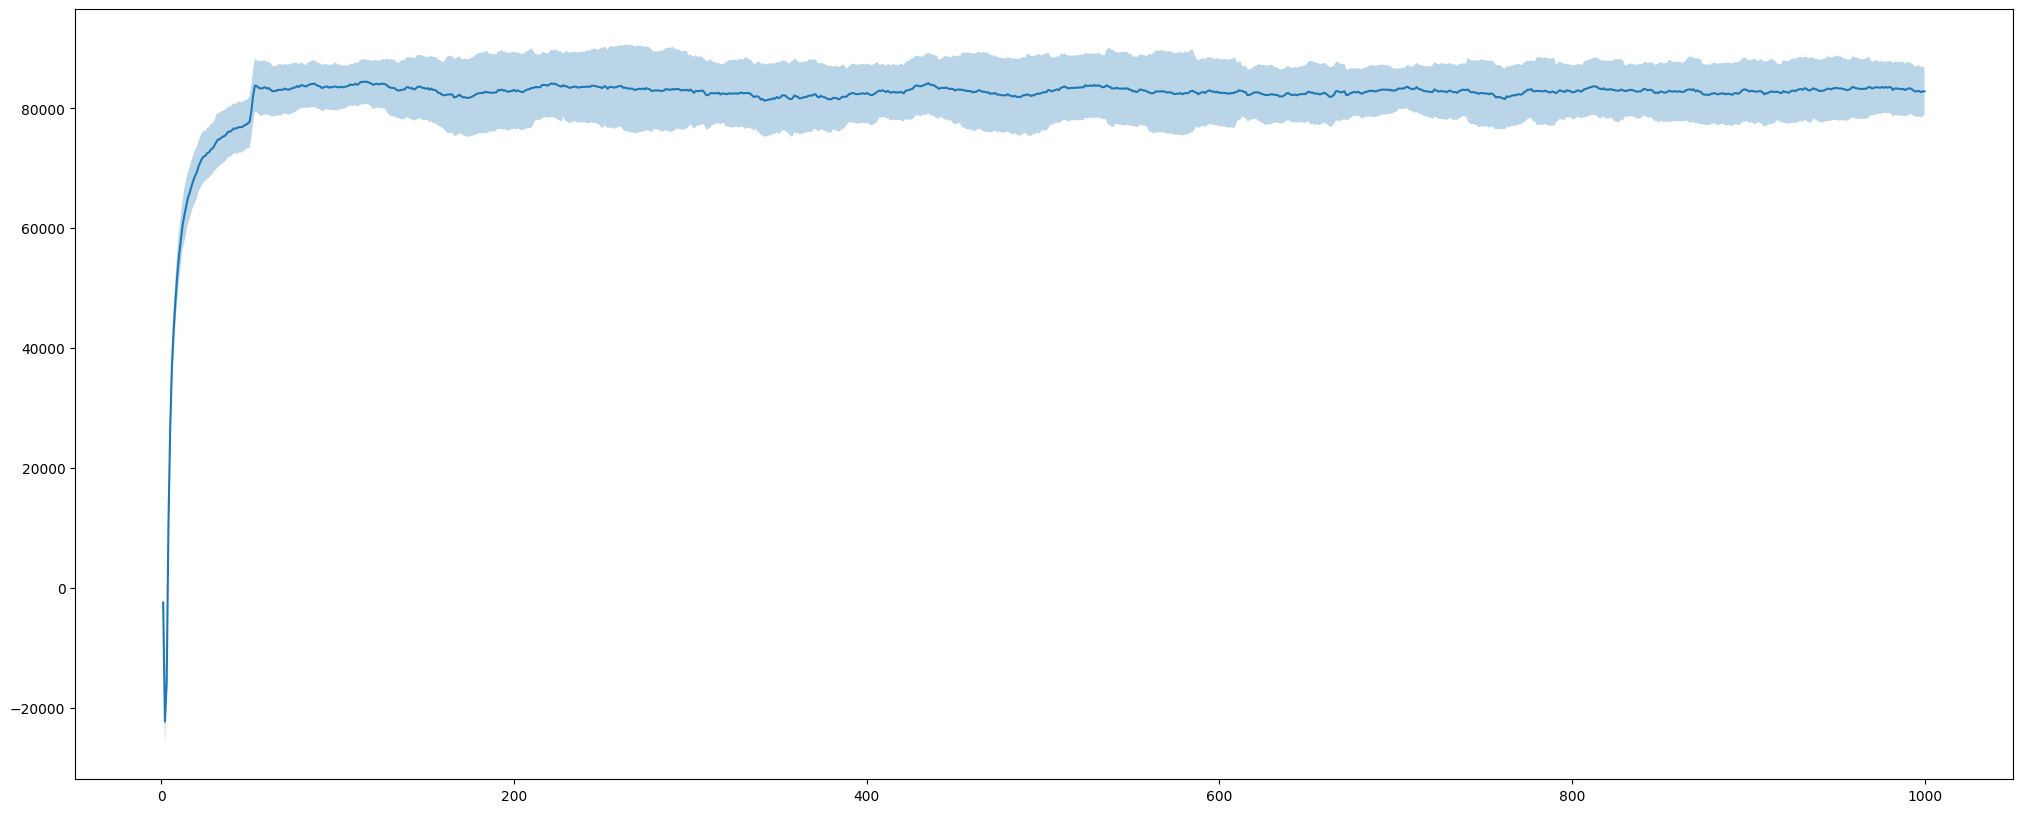

In [17]:
from matplotlib import pyplot as plt
plt.figure(figsize=(25,10))
plt.plot(np.array([n+1 for n in range(1000)]), np.array(avg_reward_list))
plt.fill_between(np.array([n+1 for n in range(1000)]), 
                 np.array(avg_reward_list) - np.array(std_reward_list), 
                 np.array(avg_reward_list) + np.array(std_reward_list), 
                 alpha=0.3)

In [ ]:
### check the status of demands (D) over the 52 weeks of a typical simulation episodic period
env.D

array([   0., 2460., 2415., 2495., 2455., 2536., 2508., 2489., 2565.,
       2543., 2446., 2587., 2489., 2457., 2549., 2491., 2578., 2548.,
       2493., 2468., 2501., 2569., 2513., 2484., 2581., 2487., 2538.,
       2492., 2520., 2493., 2583., 2473., 2451., 2488., 2518., 2566.,
       2506., 2511., 2610., 2391., 2547., 2457., 2518., 2440., 2489.,
       2594., 2437., 2489., 2505., 2471., 2546., 2469., 2501., 2510.,
       2510., 2483., 2410., 2457., 2474., 2507., 2492., 2538., 2514.,
       2559., 2445., 2396., 2521., 2548.])

In [ ]:
### check the status of planned inventory across the 3 inter-stages over the maximum lead-time (7 weeks + 1) at the end of a typical simulation episodic period
env.state

array([   0., 2550., 4481., 2576., 2564., 2497., 2576., 2545., 2428.,
       2573., 2530., 2507., 2552., 2477., 2477., 2572., 2465., 2544.,
       2425., 2464., 2427., 2510., 2538., 2548.])

In [ ]:
### check the status/changes of available inventory (I) across the 3 inter-stages over the 52 weeks of a typical simulation episodic period
env.I

array([[10000., 15000., 20000.],
       [10216., 12494., 17482.],
       [ 7804.,  9947., 15007.],
       [ 5549.,  7458., 12439.],
       [ 5440.,  5041.,  9909.],
       [ 6008.,  2451.,  7437.],
       [ 5934.,     0.,  5008.],
       [ 5849.,     0.,  5015.],
       [ 6560.,  2518.,  5130.],
       [ 6476.,  2475.,  5127.],
       [ 4014.,  2568.,  5057.],
       [ 1585.,  2530.,  5165.],
       [ 1532.,  2472.,  5202.],
       [ 1507.,  2429.,  5213.],
       [ 1777.,  2521.,  5205.],
       [ 1824.,  2514.,  5229.],
       [ 1779.,  2538.,  5204.],
       [ 1636.,  2542.,  5088.],
       [ 1666.,  2413.,  5128.],
       [ 1736.,  2495.,  4916.],
       [ 1805.,  2449.,  4840.],
       [ 1917.,  2530.,  4755.],
       [ 1618.,  2471.,  4658.],
       [ 1593.,  2522.,  4616.],
       [ 1569.,  2587.,  4648.],
       [ 1549.,  2496.,  4580.],
       [ 1340.,  2640.,  4701.],
       [  741.,  2558.,  4706.],
       [  606.,  2536.,  4846.],
       [  599.,  2503.,  4728.],
       [  

In [ ]:
### check the status/changes of backlogs/out-of-stock (B) across the 4 stages/echelons over the 52 weeks of a typical simulation episodic period
env.B

array([[   0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.],
       [   0.,   30.,    0.,    0.],
       [   0., 2558.,    0.,    0.],
       [   0., 4967.,    0.,    0.],
       [   0., 4914.,    0.,    0.],
       [   0., 4910.,    0.,    0.],
       [   0., 4755.,    0.,    0.],
       [   0., 4790.,    0.,    0.],
       [   0., 4833.,    0.,    0.],
       [   0., 4848.,    0.,    0.],
       [   0., 4791.,    0.,    0.],
       [   0., 4753.,    0.,    0.],
       [   0., 4759.,    0.,    0.],
       [   0., 4693.,    0.,    0.],
       [   0., 4834.,    0.,    0.],
       [   0., 4796.,    0.,    0.],
       [   0., 4873.,    0.,    0.],
       [   0., 4835.,    0.,    0.],
       [   0., 4872.,    0.,    0.],
       [   0., 4833.,    0.,    0.],
       [   0., 4712.,    0.,    0.],
       [   0., 4666.,    0.,    0.],
       [   0., 4612.,    0.,    0.],
 

In [ ]:
### check the status/changes of required replenishment ordered quantities (R) across the 3 inter-stages over the 52 weeks of a typical simulation episodic period
env.R

array([[2506., 2518., 2528.],
       [2547., 2475., 2629.],
       [2489., 2568., 2535.],
       [2417., 2530., 2472.],
       [2590., 2472., 2521.],
       [2451., 2429., 2532.],
       [   0., 2521., 2460.],
       [   0., 2514., 2522.],
       [2518., 2538., 2495.],
       [2475., 2542., 2497.],
       [2568., 2413., 2471.],
       [2530., 2495., 2536.],
       [2472., 2449., 2428.],
       [2429., 2530., 2482.],
       [2521., 2471., 2451.],
       [2514., 2522., 2406.],
       [2538., 2587., 2455.],
       [2542., 2496., 2550.],
       [2413., 2640., 2464.],
       [2495., 2558., 2566.],
       [2449., 2536., 2498.],
       [2530., 2503., 2607.],
       [2471., 2497., 2501.],
       [2522., 2518., 2455.],
       [2587., 2532., 2456.],
       [2496., 2445., 2504.],
       [2640., 2493., 2501.],
       [2558., 2467., 2489.],
       [2536., 2619., 2498.],
       [2503., 2463., 2421.],
       [2497., 2452., 2416.],
       [2518., 2487., 2499.],
       [2532., 2442., 2528.],
       [24

In [ ]:
### check the status/changes of actions (required replenishments + backlogs) across the 3 inter-stages over the 52 weeks of a typical simulation episodic period
env.action_log

array([[2506., 2518., 2528.],
       [2547., 2475., 2629.],
       [2489., 2568., 2535.],
       [2417., 2530., 2472.],
       [2590., 2472., 2521.],
       [2481., 2429., 2532.],
       [2528., 2521., 2460.],
       [2409., 2514., 2522.],
       [2465., 2538., 2495.],
       [2471., 2542., 2497.],
       [2413., 2413., 2471.],
       [2565., 2495., 2536.],
       [2515., 2449., 2428.],
       [2444., 2530., 2482.],
       [2464., 2471., 2451.],
       [2476., 2522., 2406.],
       [2544., 2587., 2455.],
       [2476., 2496., 2550.],
       [2554., 2640., 2464.],
       [2457., 2558., 2566.],
       [2526., 2536., 2498.],
       [2492., 2503., 2607.],
       [2508., 2497., 2501.],
       [2483., 2518., 2455.],
       [2466., 2532., 2456.],
       [2450., 2445., 2504.],
       [2586., 2493., 2501.],
       [2554., 2467., 2489.],
       [2519., 2619., 2498.],
       [2541., 2463., 2421.],
       [2575., 2452., 2416.],
       [2508., 2487., 2499.],
       [2445., 2442., 2528.],
       [24

In [ ]:
### PPO Agent manually written implementation
##  Ref:  https://keras.io/examples/rl/ppo_cartpole/

##     modification to continuous action space:  
##        Ref:  https://github.com/nikhilbarhate99/PPO-PyTorch/blob/master/PPO.py

"""
PPO is a policy gradient method and can be used for environments with either discrete or continuous action spaces. 
It trains a stochastic policy in an on-policy way.
For each epoch, it collects a set of trajectories by sampling from the stochastic policy.
The policy is updated via a stochastic gradient ascent optimizer, while the value function is fitted via some gradient descent algorithm. 
The log-probability obtained would be for sampling of actions under the stochastic policy.
"""

class Buffer:
    def __init__(self, observation_dimensions, size, gamma, lambda_value):
        self.observation_buffer = np.zeros(
            (size, observation_dimensions), dtype=np.float32
        )
        self.action_buffer = np.zeros((size, actions.shape[0]), dtype=np.float32)
        self.advantage_buffer = np.zeros(size, dtype=np.float32)
        self.reward_buffer = np.zeros(size, dtype=np.float32)
        self.return_buffer = np.zeros(size, dtype=np.float32)
        self.value_buffer = np.zeros(size, dtype=np.float32)
        self.log_probability_buffer = np.zeros(size, dtype=np.float32)

        self.gamma = gamma
        self.lam = lambda_value
        self.pointer = 0 
        self.trajectory_start_index = 0

    def get_discounted_cumulative_sums(self, accumulated_discounted_reward, discounting_factor):
        vector = np.append(1, [1, -1 * discounting_factor])
        returns = tf.nn.conv1d(
            np.pad(accumulated_discounted_reward[::-1], len(vector) // 2).reshape(1, -1, 1),
            vector.reshape(-1, 1, 1),
            stride=1, padding='SAME' 
        )
        returns = returns.numpy()[0].reshape(-1)[1:-1]
        return returns[::-1]
        
    def store(self, observation, action, reward, value, log_probability):
        # Append one step of agent-environment interaction
        self.observation_buffer[self.pointer] = observation
        self.action_buffer[self.pointer] = action
        self.reward_buffer[self.pointer] = reward
        self.value_buffer[self.pointer] = value
        self.log_probability_buffer[self.pointer] = log_probability
        
        self.pointer += 1

    def finish_trajectory(self, last_value=0):
        # Finish the trajectory by computing advantage estimates and rewards-to-go
        path_slice = slice(self.trajectory_start_index, self.pointer)
        rewards = np.append(self.reward_buffer[path_slice], last_value)
        values = np.append(self.value_buffer[path_slice], last_value)
        deltas = self.gamma * values[1:] - values[:-1] + rewards[:-1]
        self.advantage_buffer[path_slice] = self.get_discounted_cumulative_sums(deltas, self.gamma * self.lam)
        self.return_buffer[path_slice] = self.get_discounted_cumulative_sums(rewards, self.gamma)[:-1]

        self.trajectory_start_index = self.pointer

    def get(self):
        # Get all data of the buffer and normalize the advantages
        self.pointer = 0
        self.trajectory_start_index = 0
        advantage_mean, advantage_std = (
            np.mean(self.advantage_buffer),
            np.std(self.advantage_buffer),
        )
        self.advantage_buffer = (self.advantage_buffer - advantage_mean) / advantage_std
        return (
            self.observation_buffer,
            self.action_buffer,
            self.advantage_buffer,
            self.return_buffer,
            self.log_probability_buffer,
        )

def log_probabilities(values, action):
    # get a probability from the random multivariate normal distribution
    mu = tf.math.tanh(values)
    var = tf.math.softplus(values)
    dist = tfp.distributions.MultivariateNormalDiag(loc = mu, scale_diag = var)
    log_probability = dist.log_prob(action)
    return log_probability

@tf.function
def sample_action(actor, observation):
    # Sample action from actor
    outs = actor(observation)
    action = tf.clip_by_value(outs, actions.low, actions.high)
    return outs, action

@tf.function
def train_policy(actor, policy_optimizer, 
                 observation_buffer, action_buffer, log_probability_buffer, advantage_buffer, clip_ratio,
                 state_values, reward_values):
    # Train the policy by maxizing the PPO-Clip objective
    with tf.GradientTape() as tape:
        ratio = tf.exp(
            log_probabilities(actor(observation_buffer), action_buffer) - log_probability_buffer
        )
        min_advantage = tf.where(
            advantage_buffer > 0,
            (1 + clip_ratio) * advantage_buffer,
            (1 - clip_ratio) * advantage_buffer,
        )
        policy_loss = -tf.reduce_mean(
                          tf.minimum(ratio * advantage_buffer, min_advantage)
                      ) + tf.cast(
                              tf.keras.losses.MeanSquaredError()(state_values, reward_values),
                          tf.float32
                      )
    policy_grads = tape.gradient(policy_loss, actor.trainable_variables)
    policy_optimizer.apply_gradients(zip(policy_grads, actor.trainable_variables))

    kl = tf.keras.losses.KLDivergence()(
        log_probability_buffer, 
        log_probabilities(actor(observation_buffer), action_buffer)
        )
    return kl

@tf.function
def train_value_function(critic, value_optimizer, action_buffer, observation_buffer, return_buffer):
    # Train the value function by regression on mean-squared error
    with tf.GradientTape() as tape:
        value_loss = tf.reduce_mean((return_buffer - critic([action_buffer, observation_buffer])) ** 2)
        
    value_grads = tape.gradient(value_loss, critic.trainable_variables)
    value_optimizer.apply_gradients(zip(value_grads, critic.trainable_variables))

In [ ]:
observation_dimensions = states.shape[0]
num_actions = actions.shape[0]

## Network class
ddpgNN = DDPGNet(n_layer = 7, 
                 n_latent_dim = (32, 64, 128, 256, 128, 64, 32), 
                 n_states = states.shape[0], 
                 n_actions = actions.shape[0], 
                 batch_size = 16)
## Define actor networks
actor_model = ddpgNN.actor_model
critic_model = ddpgNN.critic_model

## Define optimizer
critic_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)
actor_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)

## Define hyperparameters for PPO
total_episodes = 1000
gamma = 0.99              ## discount factor
tau = 0.005               ## target update for the networks
lambda_value = 0.95                ## TD-lambda computation:  advantage estimates for the completed trajectory
advantage_clip_ratio = 0.02        ## importance clipping ratio for PPO objective
target_kl = 0.01                   ## desired KL target for policy updates
train_policy_iterations = 50
train_value_iterations = 50

## Define training loop parameters
num_iterations = 52 * total_episodes
warm_up_steps = 1040
replay_buffer_max_length = 520
steps_per_epoch = 52

In [24]:
observation = env.reset()
episode_return = 0
buffer = Buffer(observation_dimensions, steps_per_epoch, gamma, lambda_value)

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []
std_reward_list = []

for epoch in range(total_episodes):
    # Initialize the sum of the returns, lengths and number of episodes for each epoch
    sum_return = 0
    num_steps = 0
    ep_returns = []

    # Iterate over the steps of each epoch
    for t in range(steps_per_epoch):
        # Get the logits, action, and take one step in the environment
        observation = observation.reshape(1, -1)
        out_values, action = sample_action(actor_model, observation)
        observation_new, reward, done, _ = env.step(action[0].numpy())
        episode_return += reward

        # Get the value and log-probability of the action
        value_t = critic_model([action, observation])
        log_probability_t = log_probabilities(out_values, action)

        # Store obs, act, rew, v_t, logp_pi_t
        buffer.store(observation, action.numpy(), reward, value_t, log_probability_t)

        # Update the observation
        observation = observation_new

        # Finish trajectory if reached to a terminal state
        terminal = done
        if terminal == True or (t == steps_per_epoch - 1):
            last_value = 0 if done else critic_model(observation.reshape(1, -1))
            buffer.finish_trajectory(last_value)
            sum_return += episode_return
            num_steps += 1

            observation = env.reset()
            episode_return = 0

            break
            
        ep_returns.append(reward)

    # Get values from the buffer
    (
      observation_buffer,
      action_buffer,
      advantage_buffer,
      return_buffer,
      log_probability_buffer,
    ) = buffer.get()

    # Normalizing the rewards
    norm_rewards = (reward - tf.math.reduce_mean(reward)) / (tf.math.reduce_std(reward) + 1e-7)
    norm_value_t = (value_t - tf.math.reduce_mean(value_t)) / (tf.math.reduce_std(value_t) + 1e-7)

    # Update the policy and implement early stopping using KL divergence
    for _ in range(train_policy_iterations):
        kl = train_policy(actor_model, actor_optimizer, 
                          observation_buffer, action_buffer, log_probability_buffer, advantage_buffer, advantage_clip_ratio, 
                          norm_value_t, norm_rewards)
        if kl > 10 * target_kl:
            break

    # Update the value function
    for _ in range(train_value_iterations):
        train_value_function(critic_model, critic_optimizer, action_buffer, observation_buffer, return_buffer)

    # Print mean return and length for each epoch
    print("Episode " + str(epoch+1) + \
            ":   Average Reward = " + str(format(np.mean(ep_returns), '.6f')) + \
            ";   SD Reward = " + str(format(np.std(ep_returns), '.6f')))
    
    ep_reward_list.append(sum_return)
    avg_reward_list.append(np.mean(ep_returns))
    std_reward_list.append(np.std(ep_returns))

Episode 1:   Average Reward = 1790.731710;   SD Reward = 1231.188628
Episode 2:   Average Reward = -808.246239;   SD Reward = 784.117739
Episode 3:   Average Reward = -995.303431;   SD Reward = 33.209755
Episode 4:   Average Reward = -978.678431;   SD Reward = 150.766258
Episode 5:   Average Reward = -999.177941;   SD Reward = 5.812834
Episode 6:   Average Reward = -987.815196;   SD Reward = 86.159575
Episode 7:   Average Reward = -998.516667;   SD Reward = 10.488751
Episode 8:   Average Reward = -997.575980;   SD Reward = 17.140407
Episode 9:   Average Reward = -989.165686;   SD Reward = 76.610167
Episode 10:   Average Reward = -995.294118;   SD Reward = 33.275613
Episode 11:   Average Reward = -990.311275;   SD Reward = 68.509635
Episode 12:   Average Reward = -999.252451;   SD Reward = 5.285970
Episode 13:   Average Reward = -986.604412;   SD Reward = 94.721113
Episode 14:   Average Reward = -998.218627;   SD Reward = 12.596206
Episode 15:   Average Reward = -983.130392;   SD Reward

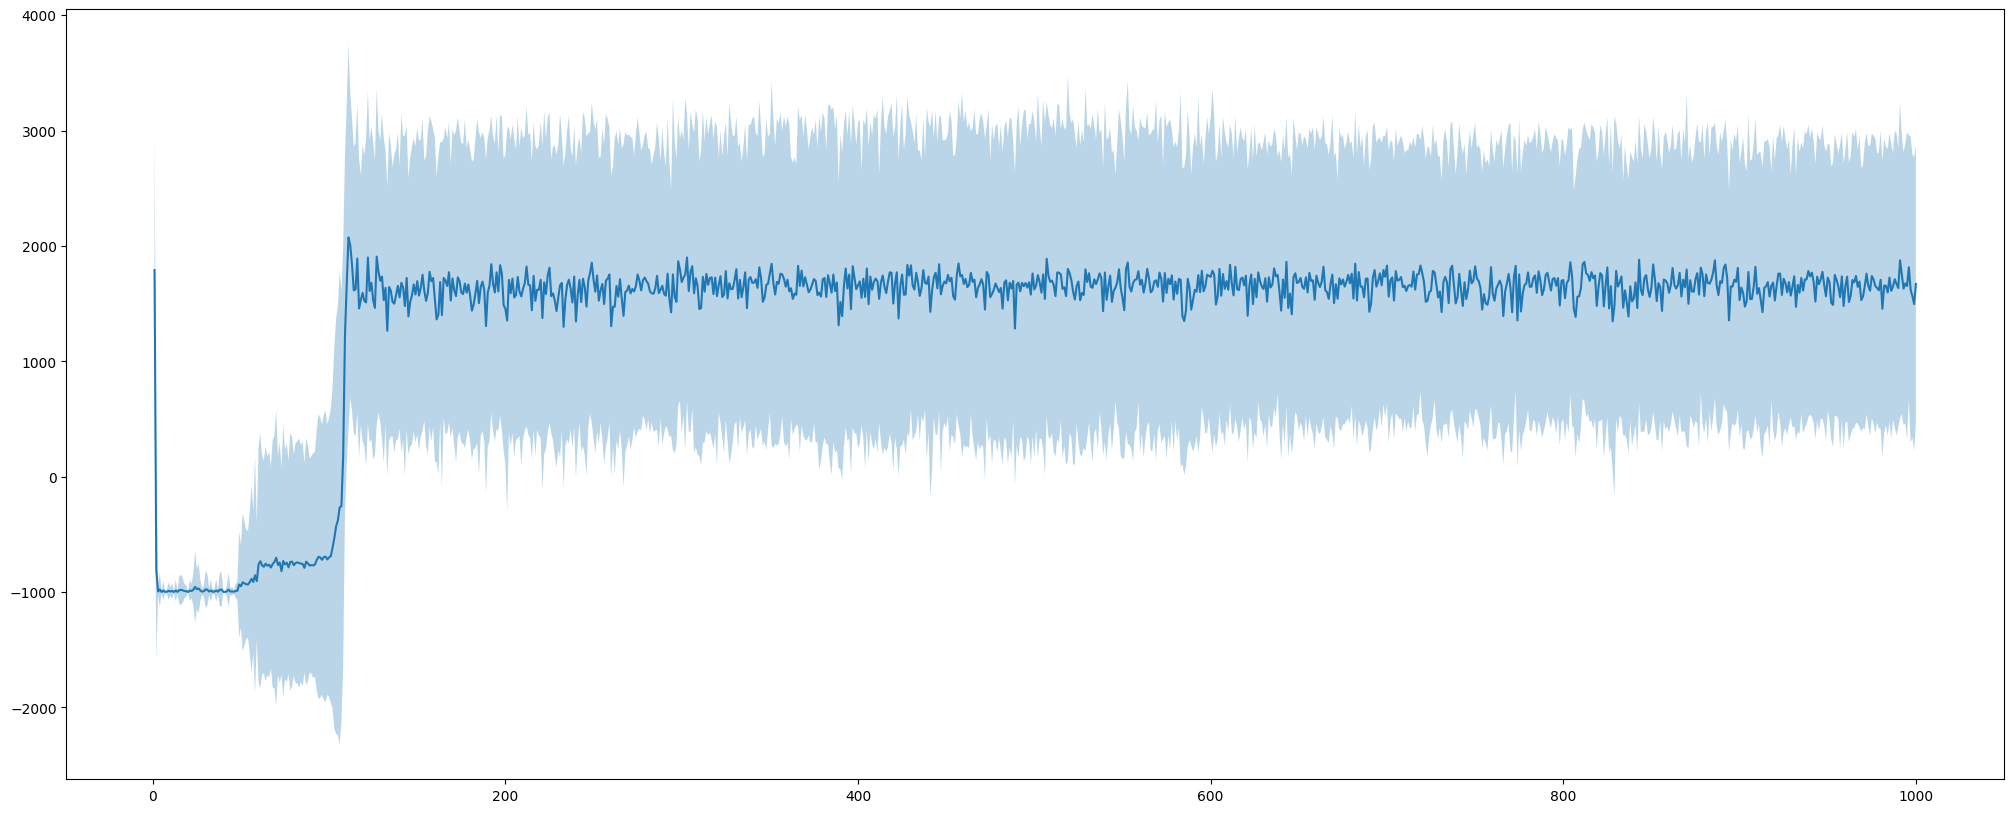

In [26]:
from matplotlib import pyplot as plt
plt.figure(figsize=(25,10))
plt.plot(np.array([n+1 for n in range(1000)]), np.array(avg_reward_list))
plt.fill_between(np.array([n+1 for n in range(1000)]), 
                 np.array(avg_reward_list) - np.array(std_reward_list), 
                 np.array(avg_reward_list) + np.array(std_reward_list), 
                 alpha=0.3)

In [ ]:
### Try other agent wrappers available in Tensorflow
from tf_agents.agents import SacAgent, PPOAgent, Td3Agent

from tf_agents.policies import random_tf_policy
from tf_agents.policies import ActorPolicy
from tf_agents.replay_buffers import TFUniformReplayBuffer
from tf_agents.environments import tf_py_environment
from tf_agents.environments import batched_py_environment
from tf_agents.environments import suite_gym

from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.trajectories import time_step
from tf_agents.trajectories import from_transition
from tf_agents.environments.gym_wrapper import spec_from_gym_space
from tf_agents.specs import ArraySpec, BoundedArraySpec
from tf_agents.specs import from_spec
from tensorflow.python.framework import tensor_spec

from tf_agents.policies import actor_policy
from tf_agents.networks import network
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import value_network
from tf_agents.agents.ddpg import critic_network, actor_network
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.agents.ppo import ppo_policy

from tf_agents.drivers import dynamic_step_driver
from tf_agents.utils import common
from tf_agents.utils import tensor_normalizer

In [ ]:
"""
To try using the Agents in Tensorflow-agent API, the PyEnv class needs to be transformed into a TFPyEnv class. 
"""
### convert gym Env to PyEnvironment
py_env = suite_gym.wrap_env(env)
### convert PyEnvironment to TFPyEnvironment
tfpy_env = tf_py_environment.TFPyEnvironment(py_env)

In [ ]:
### Set a different class of models to fit the tensorflow agent APIs

class Actor_Critic(network.Network):
    def __init__(self, n_layer, n_latent_dim: tuple, batch_size,
                 observation_specs, action_specs):
        super(Actor_Critic, self).__init__()

        assert n_layer > 1, "The number of latent layers should be greater than 1"
        assert len(n_latent_dim) == n_layer, "The tuple length of dimensions ('n_latent_dim') should be equal to or match with 'n_layer'."

        self.n_layer = n_layer
        self.n_latent_dim = n_latent_dim
        self.n_states = observation_specs.shape[0]
        self.n_actions = action_specs.shape[0]
        self.observation_specs = observation_specs
        self.action_specs = action_specs
        self.batch_size = batch_size

        self.actor_model = self.get_actor_distribution_network()
        self.actor_model_ddpg = self.get_actor_network()
        self.critic_model = self.get_critic_network()
        self.target_actor = self.get_actor_distribution_network()
        self.target_actor_ddpg = self.get_actor_network()
        self.target_critic = self.get_critic_network()

    def get_actor_distribution_network(self):
        return actor_distribution_network.ActorDistributionNetwork(
            tf.TensorSpec.from_spec(self.observation_specs), 
            tensor_spec.BoundedTensorSpec(self.action_specs.shape, 
                                            tf.float32, 
                                            (self.action_specs.minimum[0], self.action_specs.minimum[1], self.action_specs.minimum[2]), 
                                            (self.action_specs.maximum[0], self.action_specs.maximum[1], self.action_specs.maximum[2])
                                            ),
            fc_layer_params = self.n_latent_dim,
            continuous_projection_net = (tanh_normal_projection_network.TanhNormalProjectionNetwork)
            )
    
    def get_actor_network(self):
        return actor_network.ActorNetwork(
            tf.TensorSpec.from_spec(self.observation_specs), 
            tensor_spec.BoundedTensorSpec(self.action_specs.shape, 
                                        tf.float32, 
                                        (self.action_specs.minimum[0], self.action_specs.minimum[1], self.action_specs.minimum[2]), 
                                        (self.action_specs.maximum[0], self.action_specs.maximum[1], self.action_specs.maximum[2])
                                        ),
            fc_layer_params = self.n_latent_dim
            )
        
    def get_critic_network(self):
        return critic_network.CriticNetwork(
            (tf.TensorSpec.from_spec(self.observation_specs), tf.TensorSpec.from_spec(self.action_specs)),
            observation_fc_layer_params = self.n_latent_dim,
            action_fc_layer_params = None,
            joint_fc_layer_params = (self.n_actions * 2 * 8, self.n_actions * 2 * 4, self.n_actions),
            kernel_initializer='glorot_uniform',
            last_kernel_initializer='glorot_uniform'
            )

In [ ]:
## Define spec objects in tf-agents
obs_specs = spec_from_gym_space(space = env.observation_space)
action_specs = spec_from_gym_space(space = env.action_space)
action_specs = action_specs.from_spec(BoundedArraySpec(action_specs.shape, np.dtype('float32'), 
                                                       minimum = action_specs.minimum, 
                                                       maximum=action_specs.maximum))
reward_specs = ArraySpec(shape=(), dtype=np.float32)
time_step_specs = time_step.time_step_spec(obs_specs, reward_specs)

## Network class
rl_models = Actor_Critic(n_layer = 7, 
                         n_latent_dim = (32, 64, 128, 256, 128, 64, 32), 
                         observation_specs = obs_specs, 
                         action_specs = action_specs,
                         batch_size = 16)
## Define networks
actor_model = rl_models.actor_model
actor_model_ddpg = rl_models.actor_model_ddpg
critic_model = rl_models.critic_model
target_actor = rl_models.target_actor
target_actor_ddpg = rl_models.target_actor_ddpg
target_critic = rl_models.target_critic

total_episodes = 1000
## Define hyperparameters for SAC
gamma = 0.99              ## discount factor
tau = 0.005               ## target update for the networks

## Define a random policy for initial burn-in
random_policy = random_tf_policy.RandomTFPolicy(time_step_specs, action_specs)

## Define training loop parameters
num_iterations = 26000
warm_up_steps = 1040
collect_steps_per_iteration = 2
replay_buffer_max_length = 520
eval_num_episodes = 52
buffer_batch_size = 1

In [ ]:
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)

def get_replay_buffer(agent):
    replay_buffer = TFUniformReplayBuffer(
                        data_spec = agent.collect_data_spec,
                        batch_size = buffer_batch_size,
                        max_length = replay_buffer_max_length
                )
    return replay_buffer

In [ ]:
def compute_avg_return(environment, policy, eval_num_episodes):
    total_return = 0.0
    total_reward_list = []
    
    for _ in range(eval_num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        episode_return_list = []
        
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
            episode_return_list.append(time_step.reward)
            
        total_return += episode_return
        total_reward_list.append(episode_return.numpy()[0])
      
    avg_return = total_return / eval_num_episodes
    std_return = np.std(np.array(total_reward_list))
    return avg_return.numpy()[0], std_return

# Metrics
train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(buffer_size = eval_num_episodes, batch_size = buffer_batch_size),
    tf_metrics.AverageEpisodeLengthMetric(buffer_size = eval_num_episodes, batch_size = buffer_batch_size)
]

In [ ]:
## bug fix for NaN critic network issue of SAC Agent:  
##   https://github.com/tensorflow/agents/issues/622

class NormalizedActorPolicy(actor_policy.ActorPolicy):
    def __init__(self, *args, **kwargs):
        super(NormalizedActorPolicy, self).__init__(
            *args,
            observation_normalizer = tensor_normalizer.StreamingTensorNormalizer( tf.TensorSpec.from_spec(obs_specs) ),
            **kwargs
        )

## SAC
sac = SacAgent(
    time_step_spec = time_step_specs,
    action_spec = tf.TensorSpec.from_spec(action_specs),
    critic_network = critic_model,
    actor_network = actor_model,
    target_critic_network = target_critic,
    actor_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.0005),
    critic_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.0005),
    alpha_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.0005),
    actor_policy_ctor = NormalizedActorPolicy,
    target_update_tau = tau,
    gamma = gamma
)

## get replay buffer
replay_buffer = get_replay_buffer(sac)
replay_observer = [replay_buffer.add_batch]

## get replay dataset
experience_dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=52, 
    num_steps=2).prefetch(3)

iterator = iter(experience_dataset)

In [ ]:
## bug fix for Td3  --->  resolved this by using tf_agents.agents.ddpg.actor_network.ActorNetwork 
##   (tf_agents.networks.actor_distribution_network.ActorDistributionNetwork does not work.)

##   https://github.com/tensorflow/agents/issues/476

## Td3
td3 = Td3Agent(
    time_step_spec = time_step_specs,
    action_spec = tf.TensorSpec.from_spec(action_specs),
    actor_network = actor_model_ddpg,
    critic_network = critic_model,
    actor_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.0005),
    critic_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.0005),
    exploration_noise_std = 0.25,
    target_actor_network = target_actor_ddpg,
    target_critic_network = target_critic,
    gamma = gamma,
    target_update_tau = tau
)

## get replay buffer
replay_buffer = get_replay_buffer(td3)
replay_observer = [replay_buffer.add_batch]

## get replay dataset
experience_dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=52, 
    num_steps=2).prefetch(3)

iterator = iter(experience_dataset)

In [7]:
### SAC training loop
sac.initialize()

sac.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return, std_return = compute_avg_return(tfpy_env, sac.policy, eval_num_episodes)
avg_returns = [avg_return]
std_returns = [std_return]
metrics = []

for global_step in range(total_episodes):

    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(tfpy_env, sac.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = sac.train(experience).loss

    step = sac.train_step_counter.numpy()

    avg_return, std_return = compute_avg_return(tfpy_env, sac.policy, eval_num_episodes)
    print(
        "Episode " + str(step + 1) + ":   Average Reward = " + str(format(avg_return, '.6f')) + \
        ";   SD Reward = " + str(format(std_return, '.6f')) + \
        ";   Loss = " + str(format(train_loss, '.6f'))
        )
    avg_returns.append(avg_return)
    std_returns.append(std_return)
    for train_metric in train_metrics:
        train_metric.tf_summaries(train_step=global_step, step_metrics=train_metrics[:2])
    metrics.append(train_metrics)

Episode 1:   Average Reward = -37814.648438;   SD Reward = 6319.572754
Episode 2:   Average Reward = -36005.257812;   SD Reward = 6915.918945
Episode 3:   Average Reward = -31028.111328;   SD Reward = 9443.457031
Episode 4:   Average Reward = -27650.789062;   SD Reward = 12365.641602
Episode 5:   Average Reward = -21455.402344;   SD Reward = 11281.983398
Episode 6:   Average Reward = -19798.871094;   SD Reward = 11208.056641
Episode 7:   Average Reward = -12554.417969;   SD Reward = 13638.011719
Episode 8:   Average Reward = -12552.271484;   SD Reward = 13478.071289
Episode 9:   Average Reward = -13484.051758;   SD Reward = 13894.099609
Episode 10:   Average Reward = -11705.650391;   SD Reward = 11703.377930
Episode 11:   Average Reward = -2134.723145;   SD Reward = 15974.418945
Episode 12:   Average Reward = 2906.708008;   SD Reward = 16674.226562
Episode 13:   Average Reward = 8931.169922;   SD Reward = 18456.505859
Episode 14:   Average Reward = 11829.111328;   SD Reward = 19304.279

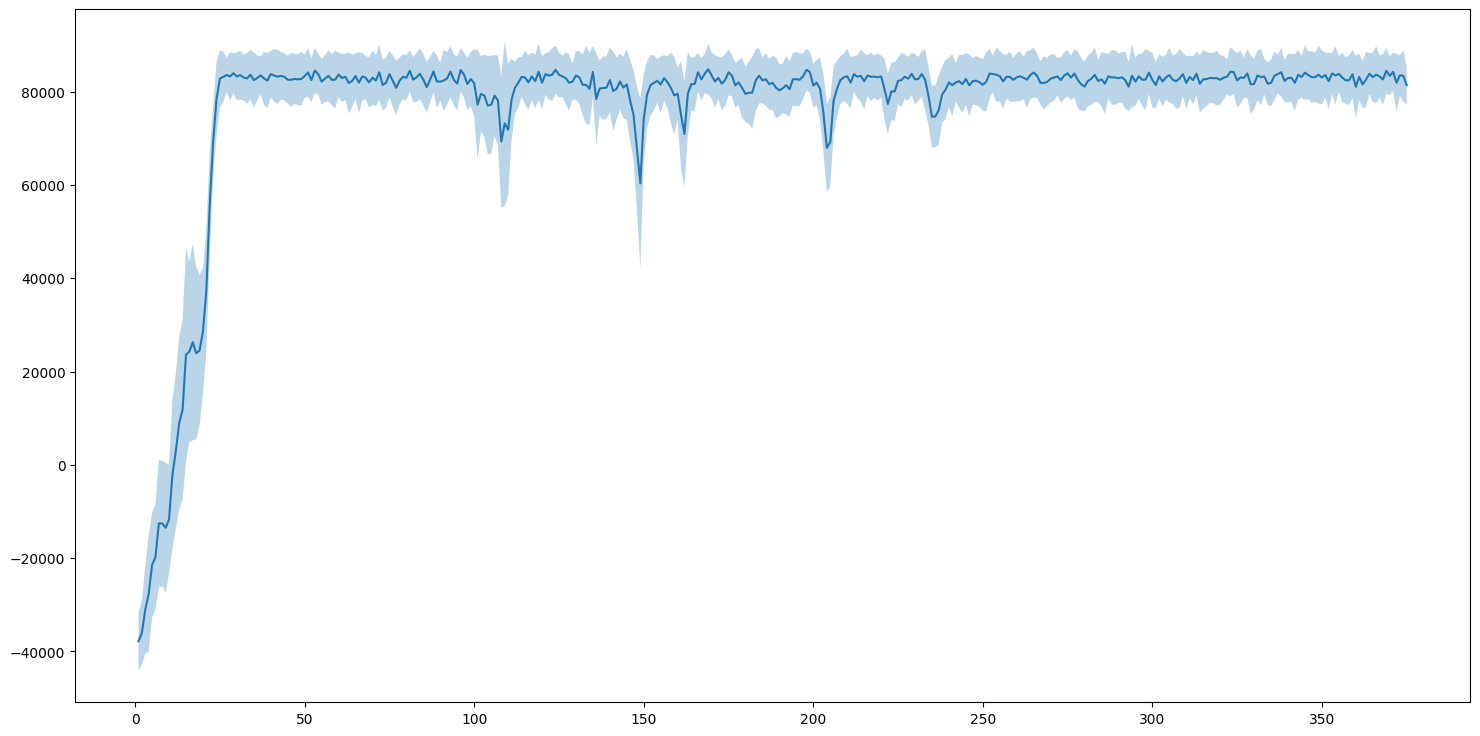

In [15]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18,9))
plt.plot(np.array([n+1 for n in range(375)]), np.array(avg_returns))
plt.fill_between(np.array([n+1 for n in range(375)]), np.array(avg_returns) - np.array(std_returns), np.array(avg_returns) + np.array(std_returns), alpha=0.3)

In [8]:
### Td3 Agent
td3.initialize()

td3.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return, std_return = compute_avg_return(tfpy_env, td3.policy, eval_num_episodes)
avg_returns = [avg_return]
std_returns = [std_return]
metrics = []

for global_step in range(num_iterations):

    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(tfpy_env, td3.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = td3.train(experience).loss

    step = td3.train_step_counter.numpy()

    avg_return, std_return = compute_avg_return(tfpy_env, td3.policy, eval_num_episodes)
    print(
    "Episode " + str(step + 1) + ":   Average Reward = " + str(format(avg_return, '.6f')) + \
    ";   SD Reward = " + str(format(std_return, '.6f'))
    )
    avg_returns.append(avg_return)
    std_returns.append(std_return)
    for train_metric in train_metrics:
        train_metric.tf_summaries(train_step=global_step, step_metrics=train_metrics[:2])
    metrics.append(train_metrics)

Episode 1:   Average Reward = -40250.875000;   SD Reward = 1635.670776
Episode 2:   Average Reward = -38918.578125;   SD Reward = 1609.042358
Episode 3:   Average Reward = -37478.796875;   SD Reward = 1418.529297
Episode 4:   Average Reward = -35105.890625;   SD Reward = 1345.180054
Episode 5:   Average Reward = -33619.253906;   SD Reward = 1452.598755
Episode 6:   Average Reward = -32744.941406;   SD Reward = 1826.682129
Episode 7:   Average Reward = -33715.804688;   SD Reward = 1560.215332
Episode 8:   Average Reward = -34880.257812;   SD Reward = 1275.486816
Episode 9:   Average Reward = -36182.152344;   SD Reward = 1961.930786
Episode 10:   Average Reward = -36605.394531;   SD Reward = 1395.635864
Episode 11:   Average Reward = -36876.660156;   SD Reward = 1558.857178
Episode 12:   Average Reward = -37194.761719;   SD Reward = 1441.886475
Episode 13:   Average Reward = -37251.863281;   SD Reward = 1536.497314
Episode 14:   Average Reward = -36683.929688;   SD Reward = 1848.511963
E

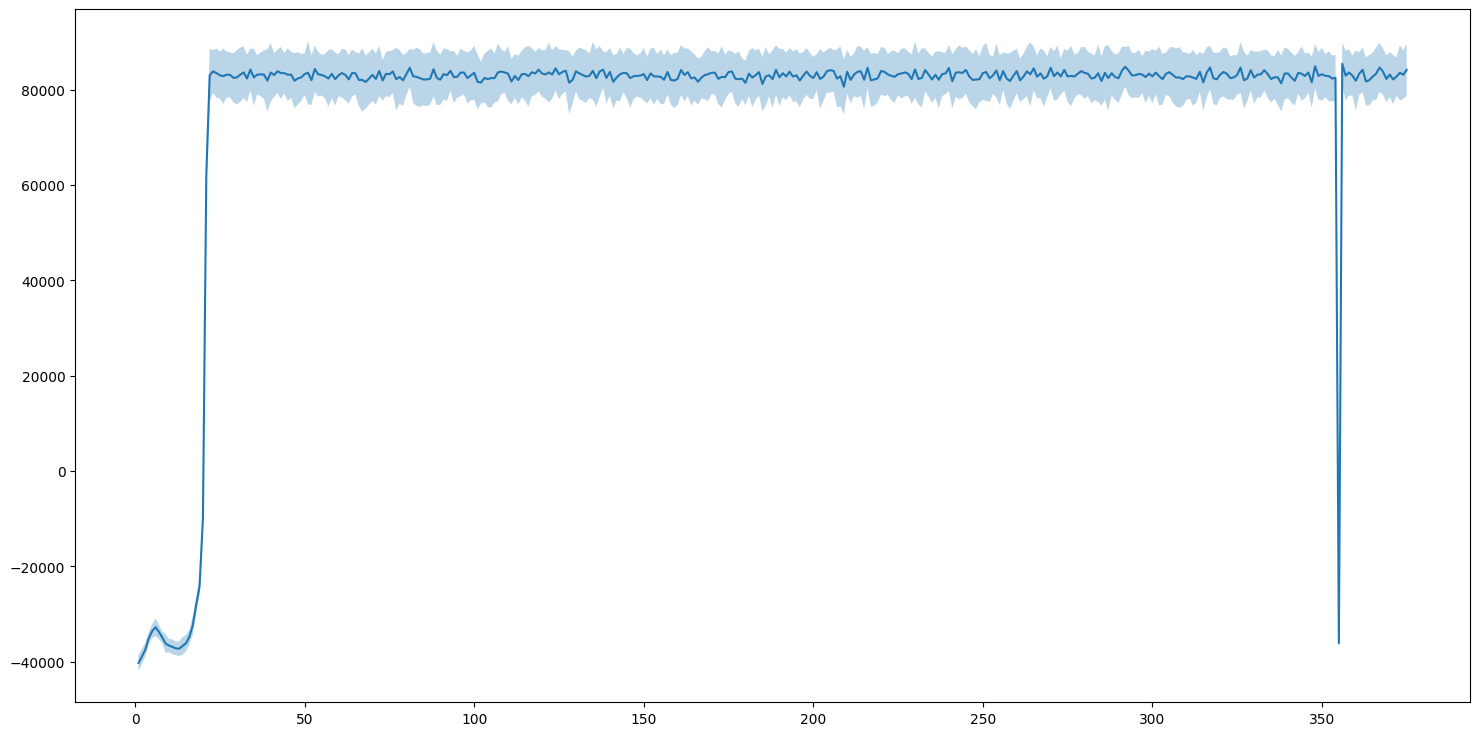

In [17]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18,9))
plt.plot(np.array([n+1 for n in range(375)]), np.array(avg_returns))
plt.fill_between(np.array([n+1 for n in range(375)]), 
                    np.array(avg_returns) - np.array(std_returns), 
                    np.array(avg_returns) + np.array(std_returns), alpha=0.3)